I decided to use Random Forest as the predictive model in this case. 

1. Because it is capable of capturing non-linear relationships between predictors and the target variable.

2. Since the number of searches can be influenced by various factors such as keyword_rank,time and the search_engine, a non-linear model like Random Forest can effectively model these complex relationships

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import colors


# Read the csv file

In [8]:
path = 'Data'

# read the file
df = pd.read_csv(f'{path}/case_study_junior_ds.csv', sep = ',')

# number of missing values in all columnsprint("\nMissing values:")
print(df.isnull().sum()) 

df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'Data/case_study_junior_ds.csv'

# Distribution 

I noticed that the df['searches'] is hugely skewed with abundance of zero values. Since we are interested in the maximum searches, I removed all zeros. These huge number of zeros introduces noise into the predictive model, that adversly affect its performance.

Here I decided to convert the target variable (df['searches']) into the logarithmic scale rather than trainig the model by the raw values. This modification improved the model's ability to capture patterns in the data. 

In [448]:
#discard all zeros
df = df[df['searches']!=0] 
#get the log of df['searches']
df['log_search'] = np.log10(df['searches']) 
#get the day for each keyword_id
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].apply(lambda x: x.day)
df.head()

,keyword_id,keyword_rank,date,searches,search_engine,log_search,day
0,338145,25218,2022-07-08,53000,0,4.724276,8
2,8590017696,136761,2022-07-08,7000,0,3.845098,8
3,8590268435,60380,2022-07-08,20033,0,4.301746,8
4,17179954797,239930,2022-07-08,2000,0,3.301030,8
6,17180015426,12517,2022-07-08,338329,0,5.529339,8


Text(0, 0.5, 'log(keyword_rank)')

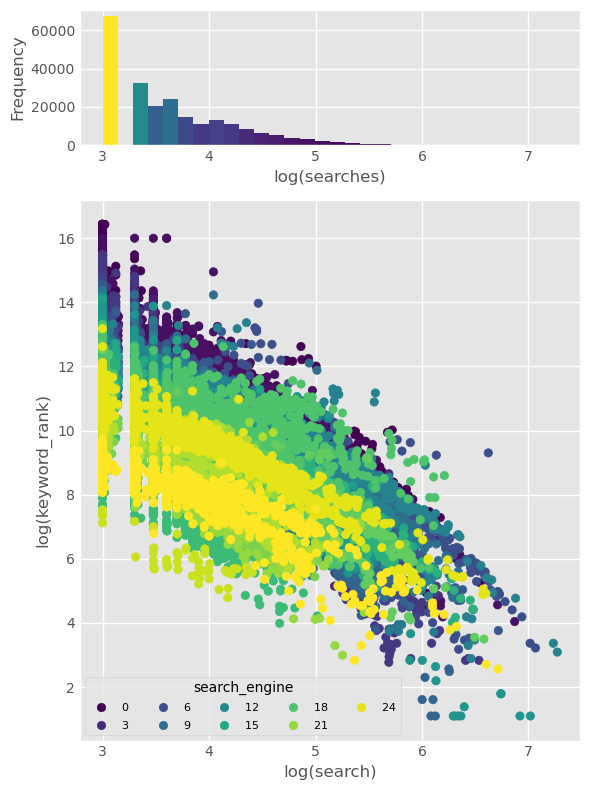

In [449]:
# visualize the raw data, scatter plot and the distribution of the log(searches)

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(6, 8),gridspec_kw={'height_ratios': [1, 4]}, tight_layout = True)


n_bins = 30
N, bins, patches = ax1.hist(df['log_search'], bins=n_bins)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
ax1.set_xlabel("log(searches)")
ax1.set_ylabel("Frequency")



scatter = ax2.scatter( df['log_search'].values, np.log(df['keyword_rank'].values),c=df.search_engine)

legend1 = ax2.legend(*scatter.legend_elements(),
                    loc="lower left", title="search_engine",ncol=5, fontsize="8")
ax.set_yticks(np.arange(0,17,2))
ax2.set_xlabel("log(search)")
ax2.set_ylabel("log(keyword_rank)")




# Random Forest Model

In [450]:
#devide the data into train and test sets with ratio (80/20)

Y = np.array(df['log_search'])
X = df.drop(['log_search','keyword_id','searches','date'], axis = 1)
X_list = list(X.columns)
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.20, random_state = 42)

print('Training Features Shape:', train_x.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_x.shape)
print('Testing Labels Shape:', test_y.shape)
print('features_list',X_list)

Training Features Shape: (182640, 3)
Training Labels Shape: (182640,)
Testing Features Shape: (45661, 3)
Testing Labels Shape: (45661,)
features_list ['keyword_rank', 'search_engine', 'day']


In [451]:
#Instantiate model with 100 decision trees
model = RandomForestRegressor(n_estimators = 30,  max_features = 'sqrt', max_depth = 10, random_state = 42)
# Train the model on training data
model.fit(train_x, train_y);

In [452]:
# Evaluate the performance of the model 

predictions = model.predict(test_x)
# calculate the mean_absolute_error between the test data and the predicted 'searches' values by the model
errors = abs(predictions - test_y)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Calculate and display accuracy
mean_absolute_percent = 100 * (errors / predictions )
accuracy = 100 - np.mean(mean_absolute_percent)

print('Accuracy', accuracy)

Mean Absolute Error: 0.14
Accuracy 96.02006197991113


Text(0.5, 0, 'log(search)')

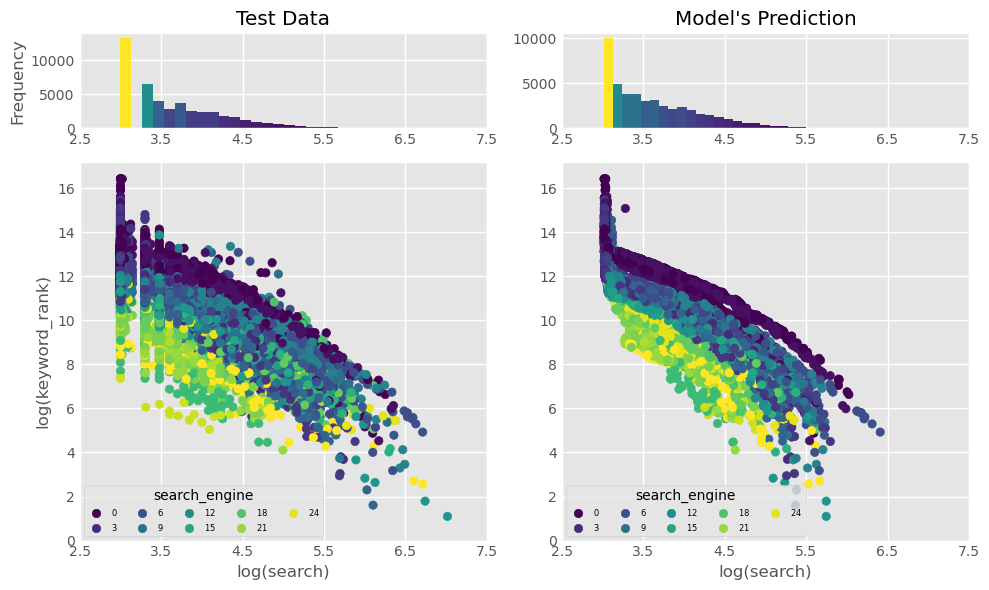

In [461]:



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 6),gridspec_kw={'height_ratios': [1, 4]}, tight_layout = True)


n_bins = 30
N1, bins1, patches1 = ax1.hist(test_y, bins=n_bins)
fracs1 = N1 / N1.max()
norm1 = colors.Normalize(fracs1.min(), fracs1.max())
for thisfrac, thispatch in zip(fracs1, patches1):
    color = plt.cm.viridis(norm1(thisfrac))
    thispatch.set_facecolor(color)
ax1.set_ylabel("Frequency")
ax1.set_xticks(np.arange(2.5,8))
ax1.set_title("Test Data")

N, bins, patches = ax2.hist(predictions, bins=n_bins)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
ax2.set_xticks(np.arange(2.5,8))
ax2.set_title("Model's Prediction")

scatter3 = ax3.scatter( test_y,np.log(test_x.keyword_rank.values), c=test_x.search_engine)
legend1 = ax3.legend(*scatter1.legend_elements(),
                    loc="lower left", title="search_engine",ncol=5, fontsize="6")
ax3.set_ylabel("log(keyword_rank)")
ax3.set_yticks(np.arange(0,17,2))
ax3.set_xticks(np.arange(2.5,8))
ax3.set_xlabel("log(search)")



scatter2 = ax4.scatter(predictions,np.log(test_x.keyword_rank.values),  c=test_x.search_engine)
legend2 = ax4.legend(*scatter2.legend_elements(),
                    loc="lower left", title="search_engine",ncol=5, fontsize="6")
ax4.set_yticks(np.arange(0,17,2))
ax4.set_xticks(np.arange(2.5,8))
ax4.set_xlabel("log(search)")





In this step, I use the trained model to forecast the 'searches' variable specifically for 'keyword_rank' equal to 1. To accomplish this, I've created a DataFrame named df_predict, with data spanning from 2022-07-08 to 2022-07-14 including of all 'search_engine' categories.

In [462]:
# create the dataframe and fill the columns 'keyword_rank', 'search_engine' and 'date' accordingly.
# Here we have 25 differnt 'search_engins' labels * 7 days (2022-07-08 to 2022-07-14) in total equals to 175 rows

days= list(set(df.day.values))
search_engins =  list(set(df.search_engine.values))
search_engin_list = [val for val in range(search_engins[0],search_engins[-1]) for _ in range(len(days))]
day_list = [val for _ in range(len(search_engins)-1) for val in days]
keyword_rank_list = [1 for i in range(len(search_engin_list ))]

# The dataset intended for input into the pre-trained model
dict_columns_pred = {'keyword_rank':keyword_rank_list,'search_engine': search_engin_list ,'day':day_list }
df_predict = pd.DataFrame(dict_columns_pred) 

# predict the searches values and store the in column named 'searches_pred'
search_log = model.predict(df_predict)
df_predict['searches_pred'] = (np.power(10,search_log )).astype(int)
# convert day to yy-mm-dd again
dates = ['2022-07-' + str(day) for day in day_list]
df_predict.insert(0, 'date', dates)
# drop the day column 
df_predict.drop('day', axis=1, inplace=True)
# export the dataframe as a csv file
df_predict.to_csv('df_pred.csv',index=False,sep=';')
# print the first 5 rows of the dataset with 'keyword_rank' == 1
df_predict.head(5)

,date,keyword_rank,search_engine,searches_pred
0,2022-07-8,1,0,510082
1,2022-07-9,1,0,601888
2,2022-07-10,1,0,2133999
3,2022-07-11,1,0,2207768
4,2022-07-12,1,0,494784


In [463]:
# use groupby to filter the maximum number of searches perd engine_search for 'keyword_rank' == 1

grouped_pred = df_predict.groupby(['search_engine']).agg({
    'searches_pred': 'max'}).reset_index()

# get the index of maximum searches per engin_search and extract the corrosponding date index
max_index = df_predict.groupby('search_engine')['searches_pred'].idxmax()
max_date = df_predict.loc[max_index, ['date','keyword_rank','search_engine' ]]

result_pred = pd.merge(max_date,grouped_pred, on='search_engine')

result_pred.to_csv('grouped_pred.csv',index=False,sep=';')
print(result_pred.head(10))

         date  keyword_rank  search_engine  searches_pred
0  2022-07-11             1              0        2207768
1  2022-07-11             1              1        2060773
2  2022-07-11             1              2         539695
3  2022-07-10             1              3         685482
4  2022-07-10             1              4         886450
5  2022-07-11             1              5         823971
6  2022-07-11             1              6        3145347
7  2022-07-11             1              7        1036944
8  2022-07-11             1              8         648986
9  2022-07-11             1              9         849918


Here, I conducted a sanity check by comparing the maximum predicted searches per search_engine for 'keyword_rank' == 1 and the searches for the lowest existing ranks in the original data per 'search_engin'. However, since the model is expected to predict [the most] extreme values, the predictions are necessarily more in line with the less extreme data points, and, therefore, the sanity check shows the data is not appropriate for the prediction of 'keyword_rank' == 1. 

To encounter this issue, I have also computed another model using inverse keyword_rank, as can be seen below. However, this model had a lower accuracy but predicted a more extreme 'keyword_rank' == 1. This compromise might be justifiable, as one might think that the accuracy of the model is related to the prediction of the less extreme ranks in general. So it is better to have a marginally less accurate model but better predictions for 'keyword_rank' == 1 prediction.


In [464]:
grouped_original = df.groupby(['search_engine']).agg({
    'searches': 'max'}).reset_index()

max_index_original = df.groupby('search_engine')['searches'].idxmax()

max_date_original = df.loc[max_index_original, ['keyword_rank','date','search_engine' ]]

result_original = pd.merge(max_date_original,grouped_original, on='search_engine')

result_original.to_csv('grouped_original.csv',index=False,sep=';')
print(result_original.head(10))

   keyword_rank       date  search_engine  searches
0           211 2022-07-10              0   4083115
1            57 2022-07-10              1   7419497
2         14412 2022-07-11              2     44000
3           128 2022-07-11              3   1421894
4            17 2022-07-10              4   3430634
5           172 2022-07-10              5   1360524
6            25 2022-07-10              6  11645099
7            43 2022-07-11              7   5210783
8            12 2022-07-10              8   1807732
9            83 2022-07-10              9   3027210
